In [17]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [18]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [19]:
# creating a table for order activity
sql = '''
select id, date(created_at), verb, driver_id, order_id, "text"
from ctms_db_public.activities_orderactivity ao
WHERE date(created_at) >= date(current_date - interval '28 days')
AND date(created_at) < date(current_date)
'''
order_activity = pd.read_sql_query(sql, con=engine)
order_activity = order_activity.rename(columns={'id': 'activity_id', 'date': 'created_at'})
order_activity

,activity_id,created_at,verb,driver_id,order_id,text
0,47651255,2020-12-11,assigned,82014.0,7733061,Assigned to PABLO ZURITA
1,47652487,2020-12-11,pickedup,50751.0,7754093,Ivan Matev marked the order as picked up from ...
2,47653719,2020-12-11,delivered,74640.0,7756230,MARK LANGDELL marked the order as delivered to...
3,47654951,2020-12-12,BOL_emailed,51567.0,7762706,BOL was emailed to duke@cli-mail.com
4,47656183,2020-12-12,assigned,73640.0,7771799,Assigned to Claudia Flores
...,...,...,...,...,...,...
1114553,48520707,2021-01-04,paid,NaN,6379750,Order was marked as paid
1114554,48521939,2021-01-04,paid,NaN,6477055,Order was marked as paid
1114555,48523171,2021-01-04,Invoice_emailed,NaN,7707032,Invoice was emailed to ap@loadrpm.com
1114556,48524403,2021-01-04,Invoice_emailed,NaN,7882998,Invoice was emailed to ship@rcglogistics.com


In [20]:
# percentage of missing values
order_activity.isna().sum()/order_activity.isna().count()

activity_id    0.000000
created_at     0.000000
verb           0.000000
driver_id      0.303394
order_id       0.000000
text           0.000000
dtype: float64

There are many missing driver_id values. I am assuming this is because some of the activities are not performed by drivers. Since we are measuring driver activity, I will delete all missing values.

In [21]:
# value counts of order activities before deleting missing values
order_activity['verb'].value_counts()

assigned                               209561
delivered                              154098
pickedup                               152123
BOL_emailed                            116197
created                                102611
paid                                    77931
imported                                75188
Invoice_emailed                         62010
unassigned                              46144
archived                                43785
deleted                                 43023
qbo_invoice_sent                         9574
qbd_invoice_sent                         4886
unarchived                               3833
Invoice_faxed                            2928
qbo_payment_sent                         2309
Invoice_fax_delivered                    2200
added_order_terminal                     1486
delivered_to_terminal                    1360
Invoice_fax_failed                        682
restored                                  664
qbd_payment_sent                  

In [22]:
# dropping all missing values
order_activity.dropna(inplace=True)

In [23]:
# value counts of order activities after dropping missing values
order_activity['verb'].value_counts()

assigned                 209561
delivered                152282
pickedup                 151164
BOL_emailed              107855
unassigned                46144
created                   30339
deleted                   25486
imported                  22626
paid                      20968
archived                   8379
delivered_to_terminal      1352
BOL_faxed                   160
unarchived                   62
reassigned                   30
Name: verb, dtype: int64

In [24]:
# we are only interested in drivers assigning loads so I am only keeping the rows where the verb is 'assigned'

order_activity = order_activity[order_activity['verb'] == 'assigned']
order_activity

,activity_id,created_at,verb,driver_id,order_id,text
0,47651255,2020-12-11,assigned,82014.0,7733061,Assigned to PABLO ZURITA
4,47656183,2020-12-12,assigned,73640.0,7771799,Assigned to Claudia Flores
21,47677127,2020-12-12,assigned,39543.0,7774191,Assigned to Valdinei Deoliveira
30,47688215,2020-12-13,assigned,32103.0,7772405,Assigned to DAMON WRIGHT
34,47693143,2020-12-14,assigned,79120.0,7776020,Assigned to David J Laird
...,...,...,...,...,...,...
1114522,48482515,2021-01-04,assigned,66369.0,7903945,Assigned to James Booker
1114539,48503459,2021-01-04,assigned,43731.0,7906772,Assigned to Derek Potter
1114543,48508387,2021-01-04,assigned,36554.0,7909460,Assigned to Scott Loghry
1114548,48514547,2021-01-04,assigned,67766.0,7907581,Assigned to Felipe Velasquez jr


In [25]:
# creating a table of drivers to get driver guid
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid', 'genericuser_ptr_id': 'driver_id'})
drivers.head()

,driver_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df


In [26]:
# joining driver_guid to order activity table

order_activity = order_activity.merge(drivers, how='inner', left_on='driver_id', right_on='driver_id')
order_activity

,activity_id,created_at,verb,driver_id,order_id,text,carrier_id,driver_guid
0,47651255,2020-12-11,assigned,82014.0,7733061,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
1,48492942,2021-01-04,assigned,82014.0,7906215,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
2,48411030,2020-12-31,assigned,82014.0,7892832,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
3,48112213,2020-12-22,assigned,82014.0,7846403,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
4,47426030,2020-12-08,assigned,82014.0,7733061,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
...,...,...,...,...,...,...,...,...
202497,47690870,2020-12-14,assigned,82782.0,7775767,Assigned to rodrigo borba,43240,7951a691-029c-4a71-b864-76dadb754665
202498,47509843,2020-12-09,assigned,63992.0,7747624,Assigned to Brian Paez,37068,1071631c-5fca-4085-891c-644ba1b22d63
202499,47833251,2020-12-16,assigned,74436.0,7800405,Assigned to Aaron Lee,40310,571344ed-7f6a-4e83-aff5-d1c20e7f7a12
202500,47942899,2020-12-18,assigned,83236.0,7819398,Assigned to REGINALD BALLARD,43412,be1a5d1a-7e39-4309-85e8-73d0f78e1b08


In [28]:
result = order_activity.groupby(['driver_id', 'driver_guid']).nunique()[['created_at']]
result.reset_index(inplace=True)
result = result.rename(columns={'created_at': 'unique_days_of_assigning_load'})

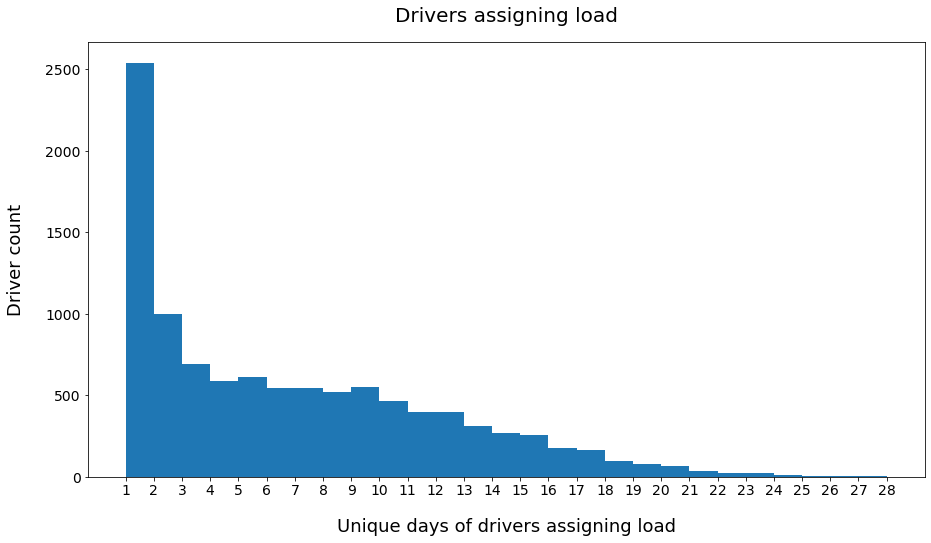

In [29]:
# histogram of unique days of driver activity (changing load status)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_of_assigning_load'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days of drivers assigning load', fontsize=18, labelpad=20)
plt.ylabel('Driver count', fontsize=18, labelpad=20)
plt.title('Drivers assigning load', fontsize=20, pad=20)
plt.show()